# Summary

A CNN-based autoencder neural architecture, similar to UNET but with no skip connections, to predict the state changes of the (colliding) gaussian bubbles.

# Imports

In [1]:
import os
import copy
import time
import numpy as np
import scipy as sp
import scipy.sparse as sprse
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import tqdm
import torch
from tqdm.notebook import tqdm_notebook
from torchvision.transforms import v2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.animation as animation
import torch.optim as optim
from torch import nn
from PIL import Image
import requests
from io import BytesIO

# Dataset Configuration

Configuration class for for the dataset side of the program.

In [2]:
class datasetConfig:
    fixed_seq_len = 216
    path = '/data/users/jupyter-dam724/datadump(colliding)'
    solver = 'ros2'
    seed = 32
    
    device_pref = 'cuda'
    device = None
    
    batch_size = 64
    num_workers = 32
    loader_speed = False

*Seed torch for reproducibility.*

In [3]:
torch.manual_seed(datasetConfig.seed)

# Data/Setup

Caching filepaths, seting up device, and data diagnostic tools.

*Any files that end before the final timestep (216) have a sequence length of (final_step - 10) due to the chaotic of their final timesteps.*

*All iterations after 240 MUST be used for training (these do not have A/b).*

In [4]:
def set_device(device_pref):
    device = None
    
    if device_pref == 'cuda' and torch.cuda.is_available():
        device = torch.device('cuda:2')
        print('Now using GPU.')
    else:
        device = torch.device('cpu')
        if device_pref == 'cuda':
            print('GPU not available, defaulting to CPU.')
        else:
            print('Now using CPU.')
    
    return device

In [5]:
def get_num_instances(folder):
    inst = set()
    
    for filename in os.listdir(folder):
        if filename.split('_')[2] in inst:
            continue
        inst.add(int(filename.split('_')[2]))
    
    return inst

In [6]:
def get_training_lens(folder, instances):
    inst_len_cache = {}
    
    for instance in instances:
        x = os.path.join(folder, f'{datasetConfig.solver}_x_{instance}_')
        
        for seq in range(0, datasetConfig.fixed_seq_len+1):
            x_seq = x + f'{seq}.npy'
            
            if not os.path.isfile(x_seq):
                # If finished early use timesteps 10 before.
                if seq != datasetConfig.fixed_seq_len:
                    inst_len_cache[instance] = seq-10
                else:
                    inst_len_cache[instance] = seq-1
                break
                
    return inst_len_cache

In [7]:
def get_training_paths(folder, instances, inst_len_cache):
    file_cache = {}
        
    for instance in instances:
        for seq in range(inst_len_cache[1]+1):
            x_file = f'x_{instance}_{seq}'
            
            file_cache[x_file] = os.path.join(folder, f'{datasetConfig.solver}_{x_file}.npy')
    
    return file_cache

In [8]:
instances = get_num_instances(datasetConfig.path)
seq_len_cache = get_training_lens(datasetConfig.path, instances)
file_cache = get_training_paths(datasetConfig.path, instances, seq_len_cache)

In [9]:
def print_diagnostics(seq_len_cache, file_cache):
    print(f'Number of file paths cached: {len(file_cache)}')
    print('Key: x_{i}_{n}, Value: /data/users/jupyter-dam724/datadump(colliding)/ros2_x_{i}_{m}.npy\n')

    print('Inst | Seq. Len. \n================')
    for key, val in seq_len_cache.items():
        if val < 215:
            # Denote the true value of problem instances. Investigate if need be.
            print(f'{key:4} | {val:3} <-- {val+10}')
        else:
            print(f'{key:4} | {val:3}')

In [10]:
print_diagnostics(seq_len_cache, file_cache)

Number of file paths cached: 203040
Key: x_{i}_{n}, Value: /data/users/jupyter-dam724/datadump(colliding)/ros2_x_{i}_{m}.npy

Inst | Seq. Len. 
   1 | 215
   2 | 215
   3 | 215
   4 | 215
   5 | 215
   6 | 215
   7 | 215
   8 | 215
   9 | 215
  10 | 192 <-- 202
  11 | 215
  12 | 215
  13 | 215
  14 | 215
  15 | 215
  16 | 215
  17 | 215
  18 | 215
  19 | 215
  20 | 161 <-- 171
  21 | 215
  22 | 215
  23 | 215
  24 | 215
  25 | 215
  26 | 215
  27 | 215
  28 | 215
  29 | 156 <-- 166
  30 | 215
  31 | 215
  32 | 215
  33 | 215
  34 | 215
  35 | 215
  36 | 215
  37 | 215
  38 | 215
  39 | 215
  40 | 182 <-- 192
  41 | 215
  42 | 215
  43 | 215
  44 | 215
  45 | 215
  46 | 189 <-- 199
  47 | 215
  48 | 215
  49 | 174 <-- 184
  50 | 215
  51 | 215
  52 | 215
  53 | 199 <-- 209
  54 | 177 <-- 187
  55 | 215
  56 | 215
  57 | 215
  58 | 215
  59 | 215
  60 | 215
  61 | 215
  62 | 215
  63 | 215
  64 | 215
  65 | 174 <-- 184
  66 | 215
  67 | 215
  68 | 201 <-- 211
  69 | 215
  70 | 215
  71 |

In [11]:
datasetConfig.device = set_device(datasetConfig.device_pref)

Now using GPU.


## Input/Target

Create an array containing all input target pairs. A helper function to delete instances is included.

In [12]:
def setup_pairs(seq_len_cache, file_cache):
    pairs = []
    
    for instance, sequences in seq_len_cache.items():
        for seq in range(sequences+1):
            if seq == sequences:
                break
            
            pair = (file_cache[f'x_{instance}_{seq}'], file_cache[f'x_{instance}_{seq+1}'])
            pairs.append(pair)
            
    return np.array(pairs)

*Deletes instance from sequences length dictionary. Once deleted seq_len_cache must be instantiated again to get back.*

In [13]:
def delete_instance(seq_len_cache, instance):
    if instance not in seq_len_cache:
        print(f'Instance {instance} not found.')
    else:
        del seq_len_cache[instance]

## Train/Validation Split

Random split, maintaing all instances with no A/b don't end up in the validation set.

*Instances (1-240) are validation, the rest are training.*

In [14]:
def train_test_split(seq_len_cache):
    train, test = {}, {}
    for key in seq_len_cache:
        if key < 241:
            test[key] = seq_len_cache[key]
        else:
            train[key] = seq_len_cache[key]
        
    return train, test

In [15]:
train_set, valid_set = train_test_split(seq_len_cache)
train_data, valid_data = setup_pairs(train_set, file_cache), setup_pairs(valid_set, file_cache)

In [16]:
print(f'Train size: {train_data.shape[0]}, Percent of toal: '
      f'{(train_data.shape[0] / (train_data.shape[0] + valid_data.shape[0])) * 100:.2f}%, '
      f'Unique instances: {len(train_set)}')
print(f'Train size: {valid_data.shape[0]}, Percent of toal: '
      f'{(valid_data.shape[0] / (train_data.shape[0] + valid_data.shape[0])) * 100:.2f}%, '
      f'Unique instances: {len(valid_set)}')

Train size: 147307, Percent of toal: 74.65%, Unique instances: 700
Train size: 50034, Percent of toal: 25.35%, Unique instances: 240


# Data-Quality/Visualization

Ensure the quality of data using visualization, helper functions for any visualization and variable conversion.

In [17]:
def get_indpendent_vars(x_vec):
    x_temp = copy.deepcopy(x_vec)
    
    x_density = x_temp[0]
    x_temp[1] = x_temp[1] / x_density
    x_temp[2] = x_temp[2] / x_density
    x_temp[3] = x_temp[3] / x_density
    
    return x_temp

In [18]:
def get_dependent_vars(x_vec):
    x_temp = copy.deepcopy(x_vec)
    
    x_density = x_temp[0]
    x_temp[1] = x_temp[1] * x_density
    x_temp[2] = x_temp[2] * x_density
    x_temp[3] = x_temp[3] * x_density
    
    return x_temp

*Visualize the input/target pairs (all variables + removed density).*

In [19]:
def visual_pairs(data, index):
    fig, ax = plt.subplots(2, 4, figsize=(16, 6))
    fig.subplots_adjust(hspace=0.5)
    inp, tar = data[index]
    instance, time = tar.split('_')[2:]
    
    inp_r, tar_r = np.load(inp), np.load(tar)
    inp_t, tar_t = inp_r.reshape(4, 100, 100), tar_r.reshape(4, 100, 100)
    inp_f, tar_f = get_indpendent_vars(inp_t), get_indpendent_vars(tar_t)
    
    fig.suptitle(f'Instance: {instance}, Timestep: {time.split(".")[0]}, Absolute Error: {np.linalg.norm(inp_t-tar_t)}')
        
    variables = ['Density', 'Horizonatal Velocity', 'Vertical Velocity', 'Temperature']
        
    for i in range(4):
        im_inp = ax[0][i].imshow(inp_f[i], origin='lower')
        im_tar = ax[1][i].imshow(tar_f[i], origin='lower')

        fig.colorbar(im_inp, ax=ax[0][i], orientation='vertical', fraction=0.046, pad=0.04)
        fig.colorbar(im_tar, ax=ax[1][i], orientation='vertical', fraction=0.046, pad=0.04)

        ax[0][i].set_title(f'{variables[i]}: Input')
        ax[1][i].set_title(f'{variables[i]}: Target')
        ax[0][i].set_xlabel('x Grid Points')
        ax[0][i].set_ylabel('y Grid Points')
        ax[1][i].set_xlabel('x Grid Points')
        ax[1][i].set_ylabel('y Grid Points')
            
    plt.show()

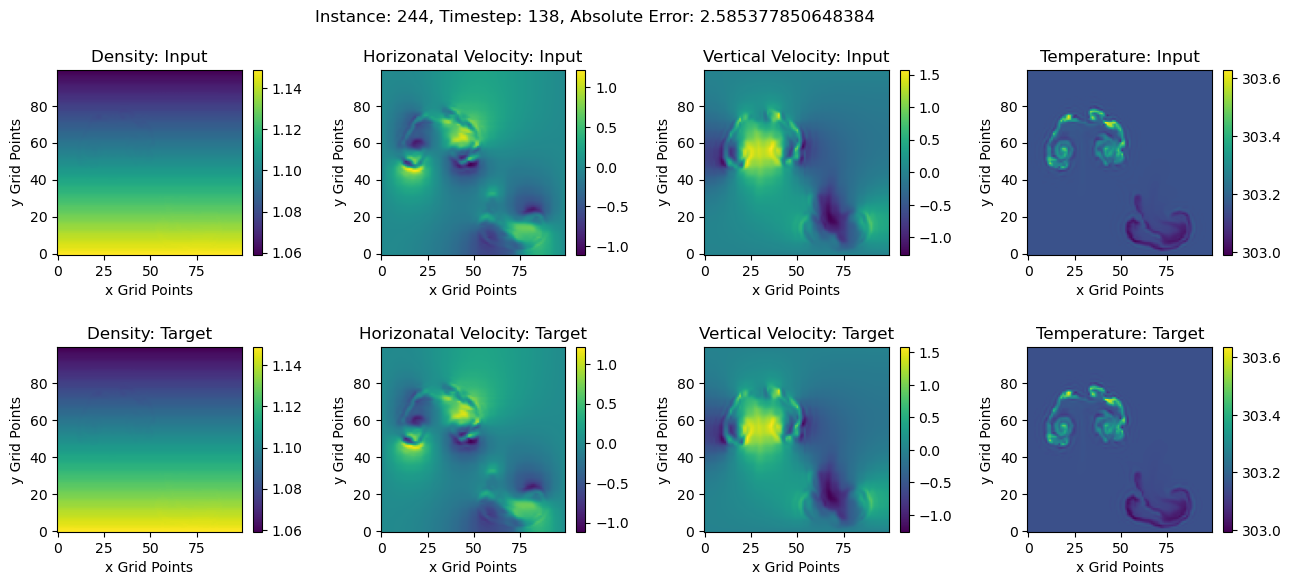

In [20]:
visual_pairs(train_data, 700)

# Data Augmentation

Transformation pipeline for computer vision tasks.

In [21]:
aug_pipeline = v2.Compose([
    v2.RandomHorizontalFlip(0.5),
    #v2.RandomVerticalFlip(0.4),
    #v2.RandomRotation((-90, 90)),
    #v2.RandomResizedCrop((100, 100), (0.8, 1.0), (3/4, 3/4))
])

# Dataset/Dataloader

Create torch dataset and dataloader.

In [22]:
def load_instances(data_instance):
    inpt = torch.from_numpy(np.load(data_instance[0])).to(dtype=torch.float32)
    target = torch.from_numpy(np.load(data_instance[1])).to(dtype=torch.float32)
    return get_indpendent_vars(inpt.view(4, 100, 100)), get_indpendent_vars(target.view(4, 100, 100))

In [23]:
def preprocess(input_tensor, target_tensor):
    std, mean = torch.std_mean(input_tensor, dim=(1, 2), keepdim=True)
    norm_input = (input_tensor - mean) / std
    norm_target = (target_tensor - mean) / std
    return norm_input, norm_target, mean, std

In [24]:
class collidingBubbles(Dataset):
    def __init__(self, data, device, loading_func, preprocess_func, data_aug=None):
        self.device = device
        self.data = data
        self.loading_func = loading_func
        self.preprocess_func = preprocess_func
        self.data_aug = data_aug

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        instance = self.data[idx]
        
        timestep = torch.tensor(int(instance[0].split('/')[-1].split('_')[-1].split('.')[0])).to(torch.float32)
        
        inpt, target = self.loading_func(instance)
        inpt, target, mean, std = self.preprocess_func(inpt, target)
        
        if self.data_aug is not None:
            inpt, target = self.data_aug(inpt), self.data_aug(target)

        # Return mean/std for visualization purposes.
        return inpt, target, mean, std, timestep

In [25]:
train_dataset = collidingBubbles(train_data, datasetConfig.device, load_instances, preprocess)
valid_dataset = collidingBubbles(valid_data,  datasetConfig.device, load_instances, preprocess)

In [26]:
train_dl = DataLoader(train_dataset, batch_size=datasetConfig.batch_size, shuffle=True, 
                      num_workers=datasetConfig.num_workers, drop_last=True, pin_memory=True)
valid_dl = DataLoader(valid_dataset, batch_size=datasetConfig.batch_size, shuffle=True, 
                      num_workers=32, drop_last=True, pin_memory=True)

In [27]:
def timeit(dl):
    start_time = time.time()
    for batch in tqdm(train_dl):
        pass
    print(f'Time with num_workers=64: {time.time() - start_time:.2f} seconds.')

In [28]:
if datasetConfig.loader_speed:
    timeit(dl)

## Tensor Helper/Visualization

Helper functions for tensors. Visualization options for tensors.

In [29]:
inputs, targets, means, stds, timesteps = next(iter(train_dl))

In [30]:
print(f'Batch input size: "{inputs.size()}", Batch target size: "{targets.size()}"')

Batch input size: "torch.Size([64, 4, 100, 100])", Batch target size: "torch.Size([64, 4, 100, 100])"


In [31]:
# TODO: Show tensor number statistics

In [32]:
def visualize_batch(batch, mean, std):
    cols = int(np.sqrt(datasetConfig.batch_size))
    rows = int(np.ceil(datasetConfig.batch_size / cols))
    
    fig, ax = plt.subplots(rows, cols, figsize=(20, 20))
    
    for col in range(cols):
        for row in range(rows):
            ind = col*cols + row
            inst_t = (batch[ind] * std[ind]) + mean[ind]
            ax[row][col].imshow(inst_t[3], origin='lower')
        
            ax[row][col].set_xticks([])
            ax[row][col].set_yticks([])

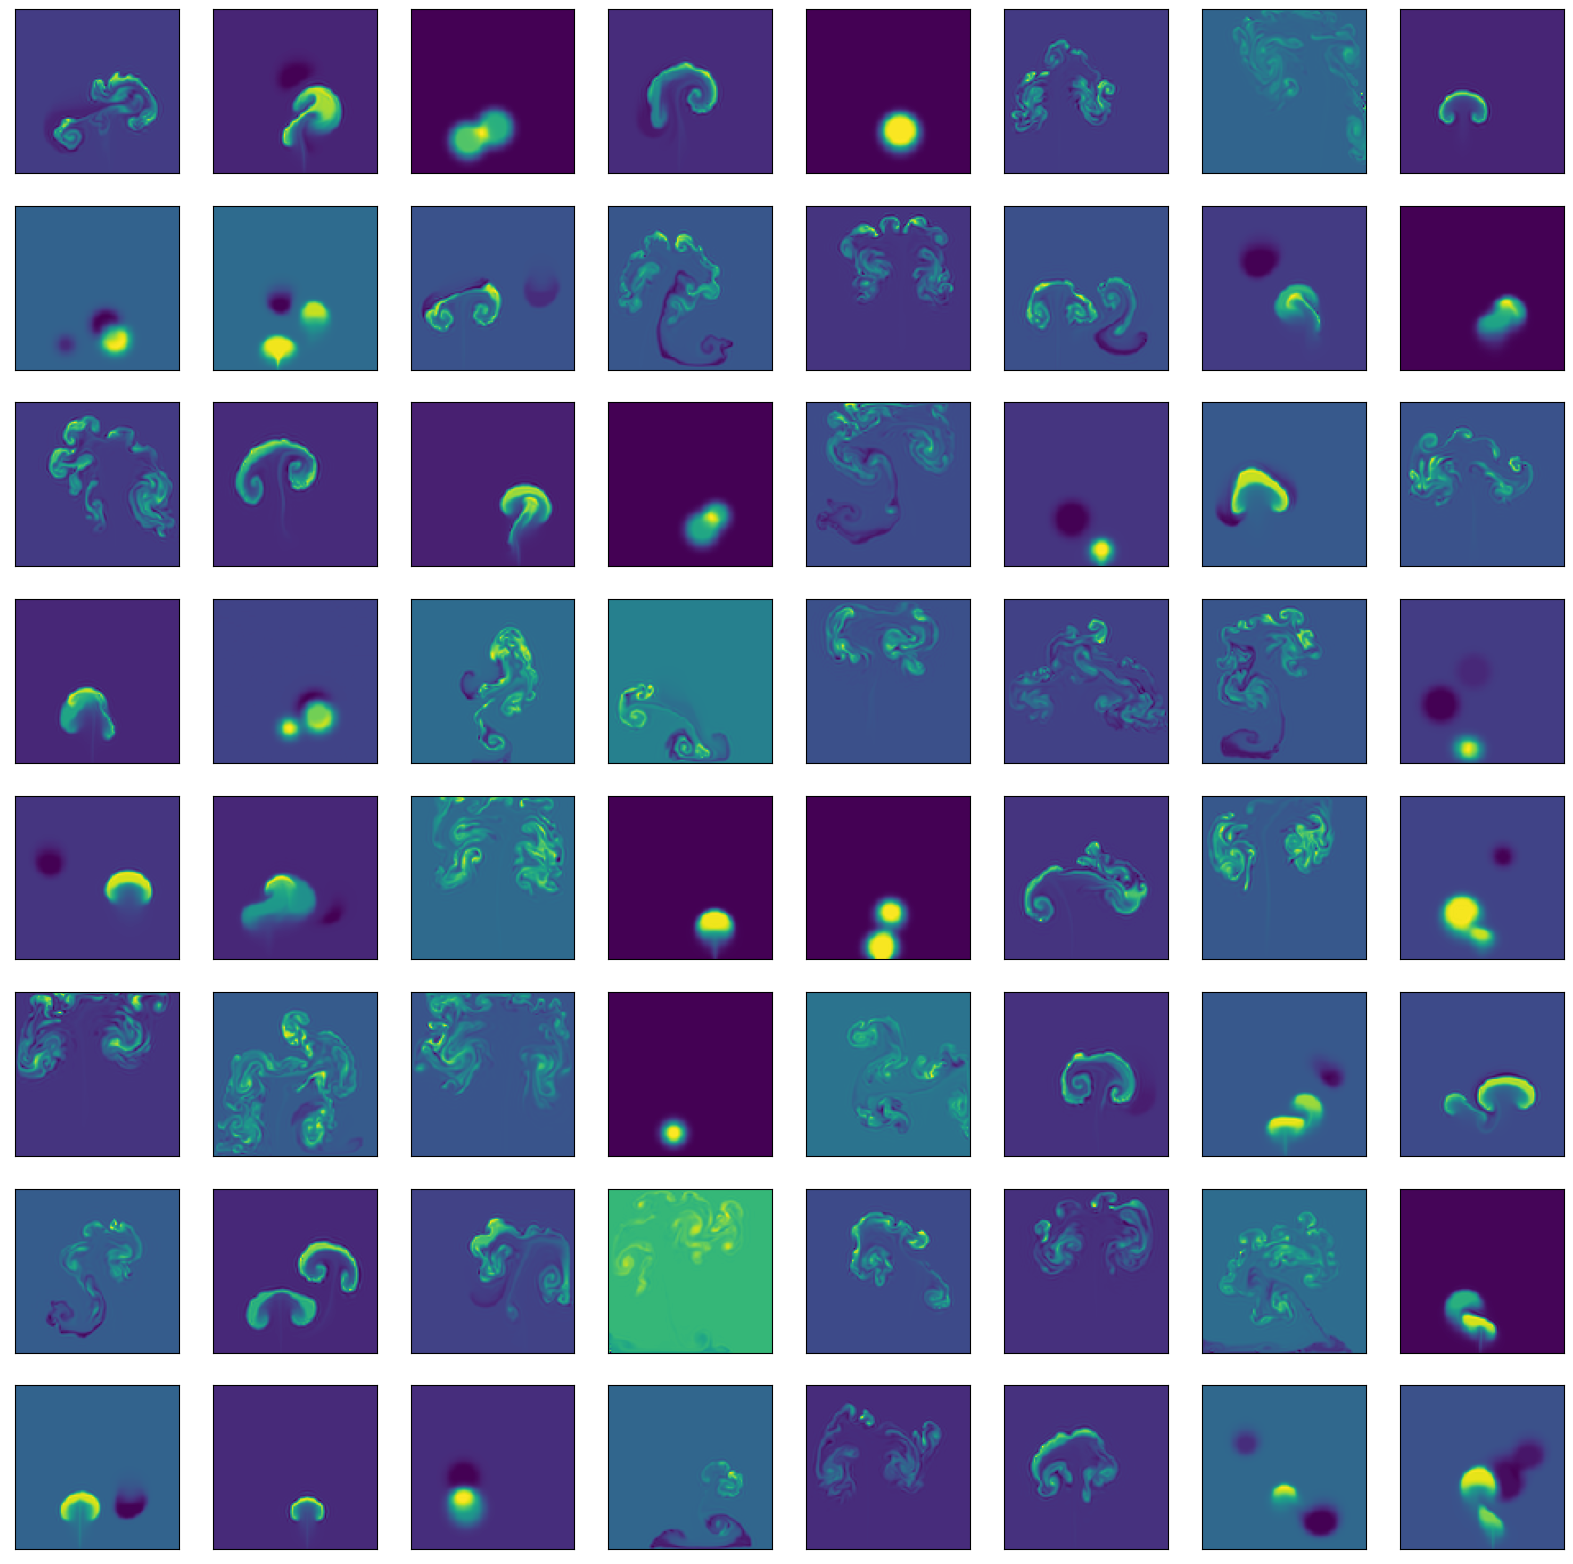

In [33]:
visualize_batch(inputs, means, stds)

## Load Model

Load model from state dict.

In [34]:
def load_model_weights(model, state_dict_path):
    state_dict = torch.load(state_dict_path)
    current_state_dict = model.state_dict()
    current_state_dict.update(state_dict)
    model.load_state_dict(current_state_dict, strict=False)
    return model

# Model Configuration

Model construction parameters: number of up-convs/down-convs, input size/channels, etc.

In [35]:
class ModelConfig:
    input_size = 100
    input_channels = 1
    output_size = 100
    output_channels = 1
    
    down_n = 4
    up_n = 4
    conv_blocks = 2
    
    latent_size = 1000
    epochs = 50
    patience = 25
    
    model = True
    model_pretrain_load = True
    model_additional_training = False

# Model Evaluation

Helper function to visualize how the models are doing.

**TODO: Change to support one variable at a time.def get_indpendent_vars(x_vec)**

In [36]:
def visual_pred(rec, inpt, pred, tar, other, mean, std, filename):
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    
    rec = (rec * std[3]) + mean[3]
    inpt = (inpt * std[3]) + mean[3]
    pred = (pred * std[3]) + mean[3]
    tar = (tar * std[3]) + mean[3]
    
    fig.suptitle(f'Reconstruction Error: {np.linalg.norm(rec-inpt)}, Prediction Error: {np.linalg.norm(pred-tar)}')
        
    variables = 'Temperature'
        
    im_rec = ax[0][0].imshow(rec[0], origin='lower')
    im_inpt = ax[0][1].imshow(inpt[0], origin='lower')
    
    im_pred = ax[1][0].imshow(pred[0], origin='lower')
    im_tar = ax[1][1].imshow(tar[0], origin='lower')

    fig.colorbar(im_rec, ax=ax[0][0], orientation='vertical', fraction=0.046, pad=0.04)
    fig.colorbar(im_inpt, ax=ax[0][1], orientation='vertical', fraction=0.046, pad=0.04)
    
    fig.colorbar(im_pred, ax=ax[1][0], orientation='vertical', fraction=0.046, pad=0.04)
    fig.colorbar(im_tar, ax=ax[1][1], orientation='vertical', fraction=0.046, pad=0.04)

    ax[0][0].set_title(f'{variables}: Reconstruction')
    ax[0][1].set_title(f'{variables}: Input')
    ax[0][0].set_xlabel('x Grid Points')
    ax[0][0].set_ylabel('y Grid Points')
    ax[0][1].set_xlabel('x Grid Points')
    ax[0][1].set_ylabel('y Grid Points')
    
    ax[1][0].set_title(f'{variables}: Prediction')
    ax[1][1].set_title(f'{variables}: Target')
    ax[1][0].set_xlabel('x Grid Points')
    ax[1][0].set_ylabel('y Grid Points')
    ax[1][1].set_xlabel('x Grid Points')
    ax[1][1].set_ylabel('y Grid Points')
            
    plt.savefig(f'{filename}.png')
    plt.show()

In [37]:
def inspect_validation_modified(inputs, targets, other, model, means, stds, ind, filename):
    inputs = inputs[:, 3, :, :].unsqueeze(1).to(datasetConfig.device)
    targets = targets[:, 3, :, :].unsqueeze(1).to(datasetConfig.device)

    model.eval()
    with torch.no_grad():
        decoder_rec, decoder_pred, _, _, _ = model(inputs, targets)
        
    visual_pred(decoder_rec[ind].cpu(), inputs[ind].cpu(), decoder_pred[ind].cpu(), targets[ind].cpu(), other[ind], means[ind], stds[ind], filename)

# Model Diagnostics

Compute model diagnostics for fully connected network.

In [38]:
def get_params(model):
    params = 0

    # Look at the parameters NOT excluding the first param. Print and examime.
    for param in model.parameters():
        l = list(param.shape)
        params += int(torch.prod(torch.tensor(l)))
            
    return params

# Ensemble Models

Create the autoencoders for each model to be loaded in.

In [39]:
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, stride, padding):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.GroupNorm(8, output_dim),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.Conv2d(output_dim, output_dim, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.GroupNorm(8, output_dim)
        )
        self.relu = nn.ReLU()
        self.drop = nn.Dropout2d(0.1)
        
        self.change_dims = True if input_dim != output_dim else False
        self.change_dim_block = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.GroupNorm(8, output_dim)
        )

    def forward(self, inpt):
        out_block = self.block(inpt)
        
        out = None
        if self.change_dims:
            out = self.change_dim_block(inpt) + out_block
        else:
            out = inpt + out_block
        
        out = self.relu(out)
        out = self.drop(out)
        return out

In [40]:
class DownConv(nn.Module):
    def __init__(self, input_dim, filter_dim, kernals, strides, paddings):
        super().__init__()
        self.layers = []
        self.pool = nn.MaxPool2d(2)
        
        self.layers.append(ResidualBlock(input_dim, filter_dim, kernals[0], strides[0], paddings[0]))
        
        for ind in range(1, len(kernals)):
            self.layers.append(ResidualBlock(filter_dim, filter_dim, kernals[ind], strides[ind], paddings[ind]))
                
        self.layers.append(self.pool)
        
        self.full_block = nn.Sequential(*self.layers)
        
    def forward(self, inpt):
        return self.full_block(inpt)

In [41]:
class UpConv(nn.Module):
    def __init__(self, filter_dim, output_dim, kernals, strides, paddings, output_padding=0):
        super().__init__()
        self.layers = []
                
        self.layers.append(ResidualBlock(filter_dim, filter_dim, kernals[0], strides[0], paddings[0]))
        
        for ind in range(1, len(kernals)):
            self.layers.append(ResidualBlock(filter_dim, filter_dim, kernals[ind], strides[ind], paddings[ind]))
            
        self.layers.append(nn.ConvTranspose2d(filter_dim, output_dim, 2, 2, 0, output_padding=output_padding))
        self.layers.append(nn.BatchNorm2d(output_dim))
        
        self.full_block = nn.Sequential(*self.layers)
        
    def forward(self, inpt):
        return self.full_block(inpt)

In [42]:
class Encoder(nn.Module):
    def __init__(self, input_dim, down_n, init_filters, conv_blocks):
        super().__init__()
        self.layers = []
        self.prev_filters = input_dim
        self.next_filters = init_filters
        
        self.kern = [3 for _ in range(conv_blocks)]
        self.stride = [1 for _ in range(conv_blocks)]
        self.pad = [1 for _ in range(conv_blocks)]
        
        self.layers.append(DownConv(self.prev_filters, self.next_filters, self.kern, self.stride, self.pad))
        self.prev_filters = self.next_filters
        self.next_filters *= 2
        
        for down_ind in range(1, down_n):
            self.layers.append(DownConv(self.prev_filters, self.next_filters, self.kern, self.stride, self.pad))
            self.prev_filters = self.next_filters
            self.next_filters *= 2
        
        self.full_block = nn.Sequential(*self.layers)
        
    def forward(self, inpt):
        return self.full_block(inpt)

In [43]:
class Decoder(nn.Module):
    def __init__(self, output_dim, up_n, init_filters, conv_blocks):
        super().__init__()
        self.layers = []
        self.prev_filters = init_filters
        self.next_filters = int(init_filters / 2)
        self.output_dim = output_dim
        
        self.kern = [3 for _ in range(conv_blocks)]
        self.stride = [1 for _ in range(conv_blocks)]
        self.pad = [1 for _ in range(conv_blocks)]
        
        for up_ind in range(0, up_n-1):
            # Fix the lost pixel when going from 25 -> 12.
            # WARNING: If the image size is not 100x100 this MAY cause issues.
            if up_n - up_ind == 3:
                self.layers.append(UpConv(self.prev_filters, self.next_filters, self.kern, self.stride, self.pad, output_padding=1))
            else:
                self.layers.append(UpConv(self.prev_filters, self.next_filters, self.kern, self.stride, self.pad))
            self.prev_filters = self.next_filters
            self.next_filters = int(self.next_filters / 2)
            
        self.layers.append(UpConv(self.prev_filters, self.output_dim, self.kern, self.stride, self.pad))
        
        self.full_block = nn.Sequential(*self.layers)
        
    def forward(self, inpt):
        return self.full_block(inpt)

In [44]:
class TempModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = Encoder(1, 4, 64, 2)
        self.decoder = Decoder(1, 4, 512, 2)
        
        self.latent1 = nn.Linear(18432, 4096)
        self.latent2 = nn.Linear(4096, 18432)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
        self.kooplatent = nn.Linear(4096, 4096, bias=False)
        
    def forward(self, inpt, tar):
        # Reconstruction.
        encoder_out = self.relu(self.flatten(self.encoder(inpt)))
        latent_down = self.latent1(encoder_out)
        
        latent_up = self.latent2(latent_down)
        latent_up_nonl = self.relu(latent_up)
        decoder_out = self.decoder(latent_up_nonl.view(64, 512, 6, 6))
        
        # Koopman Latent
        koopman_out = self.kooplatent(latent_down)
        
        encoder_pred_out = self.relu(self.flatten(self.encoder(tar)))
        latent_pred_down = self.latent1(encoder_pred_out)
        
        # Prediction
        latent_up_pred = self.latent2(koopman_out)
        latent_up_pred_nonl = self.relu(latent_up_pred)
        decoder_pred = self.decoder(latent_up_pred_nonl.view(64, 512, 6, 6))
        
        # Additional Koopman Constrain
        pred_out = self.relu(self.flatten(self.encoder(decoder_pred)))
        addional_constraint = self.latent1(pred_out)
    
        return decoder_out, decoder_pred, koopman_out, latent_pred_down, addional_constraint

In [45]:
temp_model = TempModel().to(datasetConfig.device)

### Sanity Check 01

Make sure the models are a-okay.

In [46]:
inputs, targets, means, stds, _ = next(iter(valid_dl))

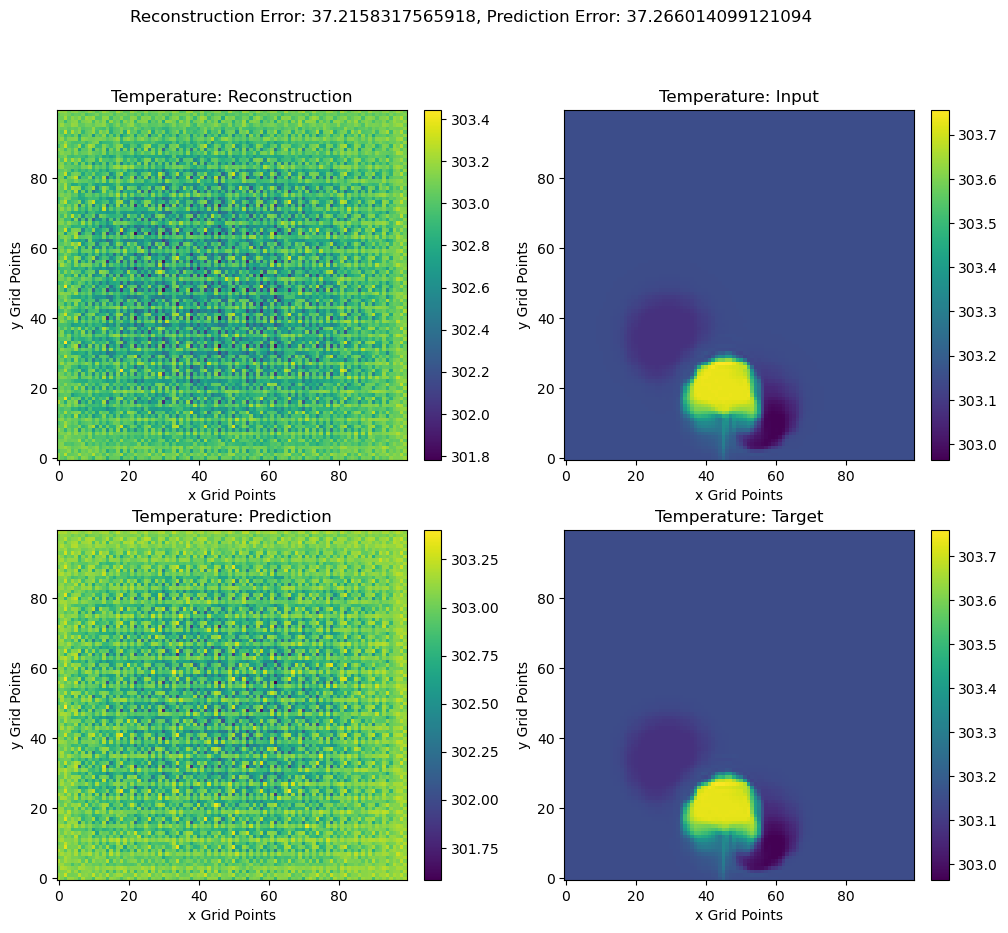

In [47]:
inspect_validation_modified(inputs, targets, inputs, temp_model, means, stds, 0, 'test')

## Model Statistics

Get number of learnable parameters in a single passthrough.

In [48]:
print(f'Learnable parameters Temp: {get_params(temp_model)}')

Learnable parameters Temp: 202951107


## Tensorboard

TODO

In [49]:
from tensorboard import notebook

logdir = '/Scripts/ModelCheckpoints/Experiment01/'

# Start TensorBoard
#notebook.start('--logdir {}'.format(logdir))

## Training Utiliy

Utility functions to help facilitate training.

In [50]:
def step_temp(batch, model, criterion):
    inputs, targets, _, _, _ = batch
    inputs = inputs[:, 3, :, :].unsqueeze(1).to(datasetConfig.device)
    targets = targets[:, 3, :, :].unsqueeze(1).to(datasetConfig.device)

    decoder_rec, decoder_pred, y_k_0, y_k_1, add = model(inputs, targets)
    loss = criterion(inputs, targets, decoder_rec, decoder_pred, y_k_0, y_k_1, add)
    return loss

In [51]:
def check_point(val_loss, best_val_loss, model, patience_counter):
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), save_path)
    else:
        patience_counter += 1
        
    return patience_counter, best_val_loss

# Training (Koopman Operator)

Training the pretrained model with aditional loses/constraints to reveal eigenfunctions.

## Training Loss

Composed of 4 different losses:
1. Reconstruction - To evaluate reconstruction of input.
2. Prediction - To evaluate prediction of next state.
3. Latent Linearity - To evaluate the linear transformation applied by the koopman operator.

In [52]:
class KoopmanLoss(nn.Module):
    def __init__(self, a1, a2, a3, a4):
        super().__init__()
        self.mse = nn.MSELoss()
        self.a1 = a1
        self.a2 = a2
        self.a3 = a3
        self.a4 = a4

    def forward(self, inpt, target, decoder_rec, decoder_pred, y_k_0, y_k_1, additional_constraint):
        reconstruction = self.mse(inpt, decoder_rec)
        prediction = self.mse(target, decoder_pred)
        linearity = self.mse(y_k_0, y_k_1)
        similar_koop1 = self.mse(additional_constraint, y_k_0)
        similar_koop2 = self.mse(additional_constraint, y_k_1)
        
        return (self.a1 * reconstruction) + (self.a2 * prediction) + (self.a3 * linearity) + (self.a4 * similar_koop1) + (self.a4 * similar_koop2)

## Training (Koopman)

Adjust/train the model to estimate the koopman transformations.

In [53]:
# Freeze the encoder.
for param in temp_model.encoder.parameters():
    param.requires_grad = True

# Freeze the decoder.
for param in temp_model.decoder.parameters():
    param.requires_grad = True

In [56]:
def train(train, valid, model, epochs, patience, criterion, lr, save_path, loading_bar=False):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        
        # Training
        model.train()
        train_loss = 0
        if loading_bar:
            loader = tqdm(train, desc=f'Training', leave=False, mininterval=2.0)
        else:
            loader = train
        
        for train_batch in loader:
            loss = step_temp(train_batch, model, criterion)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            if loading_bar:
                loader.set_postfix(train_loss=loss.item())
            
        train_loss /= len(train)

        # Validation
        model.eval()
        val_loss = 0
        if loading_bar:
            loader = tqdm(valid, desc=f'Validation', leave=False, mininterval=2.0)
        else:
            loader = valid
        
        with torch.no_grad():
            for valid_batch in loader:
                loss = step_temp(valid_batch, model, criterion)

                val_loss += loss.item()
                
                if loading_bar:
                    loader.set_postfix(val_loss=loss.item())
                
        val_loss /= len(valid)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

        patience_counter, best_val_loss = check_point(val_loss, best_val_loss, model, patience_counter)

        if patience_counter >= patience:
            print('Early stopping triggered')
            break

"new_temp_koop_with_no_independence_drop" uses a latent space of 4096 and an intitial filter size of 64. It got to roughly 0.31 on both training and validation set with a dropout of 10%.*

In [83]:
if ModelConfig.model:
    pretrain_path = 'new_temp_koop_with_no_independence_drop.pth'
    temp_model = load_model_weights(temp_model, pretrain_path)
    
    criterion = KoopmanLoss(1, 1, 1, 1)
    learning_rate = 1e-06
    save_path = 'new_temp_koop_with_no_independence_drop.pth'
    train(train_dl, valid_dl, temp_model, 75, ModelConfig.patience, criterion, learning_rate, save_path)

/tmp/ipykernel_1827893/3594389636.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path)


Epoch 1/75, Train Loss: 0.24018127400944514, Validation Loss: 0.27779249301258946
Epoch 2/75, Train Loss: 0.23974902527014208, Validation Loss: 0.2774622416488645
Epoch 3/75, Train Loss: 0.23944297836351167, Validation Loss: 0.2779074715934551
Epoch 4/75, Train Loss: 0.2391046018302052, Validation Loss: 0.2777628732437361
Epoch 5/75, Train Loss: 0.23874062468103097, Validation Loss: 0.2779806104229904
Epoch 6/75, Train Loss: 0.23846173360911416, Validation Loss: 0.277988577125625
Epoch 7/75, Train Loss: 0.23809875806276304, Validation Loss: 0.27734806692936054
Epoch 8/75, Train Loss: 0.2377498545358099, Validation Loss: 0.27738001866316214
Epoch 9/75, Train Loss: 0.23735144704593258, Validation Loss: 0.27713410163276786
Epoch 10/75, Train Loss: 0.23710464933860412, Validation Loss: 0.2772435612699897
Epoch 11/75, Train Loss: 0.23674310017854738, Validation Loss: 0.2768069442156488
Epoch 12/75, Train Loss: 0.23637291590890797, Validation Loss: 0.27689362222879704
Epoch 13/75, Train Loss

KeyboardInterrupt: 

In [81]:
inputs, targets, means, stds, _ = next(iter(valid_dl))

tensor(20.6377)


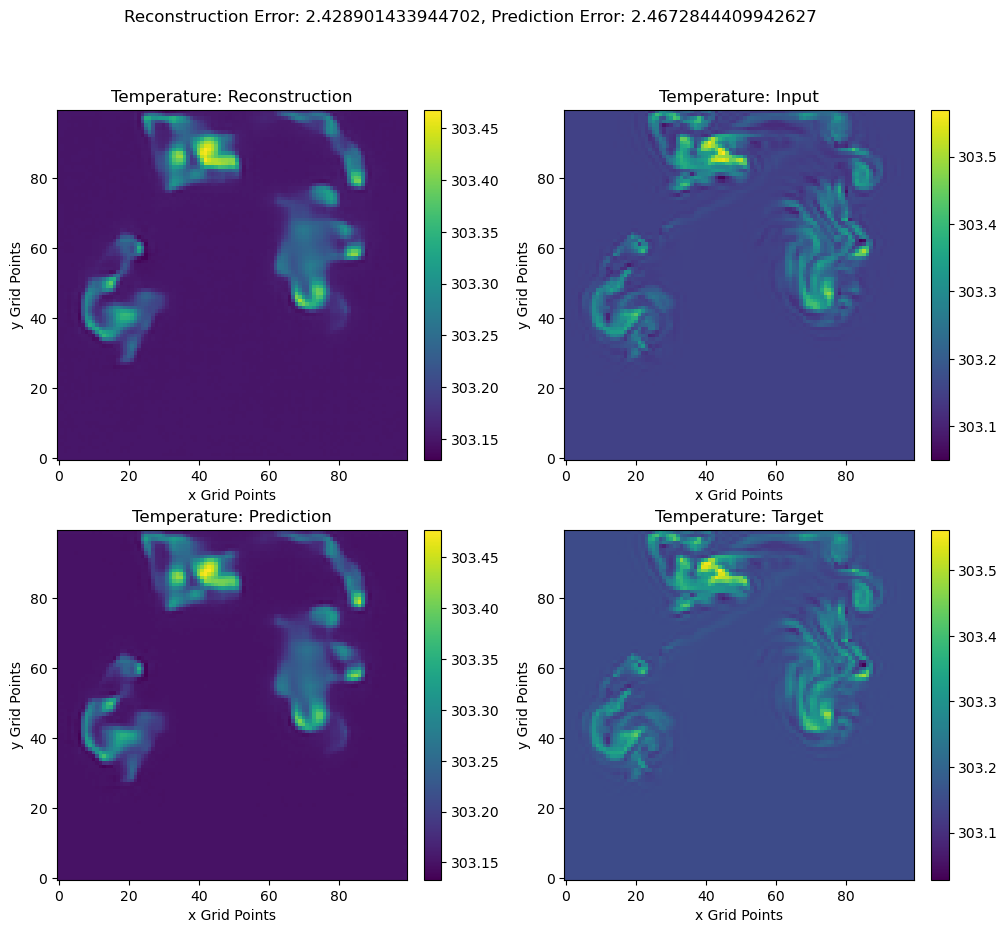

In [84]:
if ModelConfig.model:
    print(torch.linalg.norm(inputs[0][3] - targets[0][3]))
    inspect_validation_modified(inputs, targets, inputs, temp_model, means, stds, 10, 'new_temp_koop_with_no_independence_more1')

# Advance Time

Step through time and see output.data_instance

In [73]:
pred, ground = [], []

In [74]:
for i in range(0, valid_set[1]):
    inpt, target, mean, std = preprocess(*load_instances(valid_data[i]))
    ground.append(inpt[3])

In [75]:
inputs, targets, _, _ = preprocess(*load_instances(valid_data[0]))
inputs, targets = inputs.repeat(64, 1, 1, 1), targets.repeat(64, 1, 1, 1)

pred.append(inputs[0][3].unsqueeze(0))

In [76]:
if True:
    temp_model.eval()
    with torch.no_grad():
        decoder_rec, decoder_pred, _, _, _ = temp_model(inputs[:, 3, :, :].unsqueeze(1).to(datasetConfig.device), targets[:, 3, :, :].unsqueeze(1).to(datasetConfig.device))
        pred.append(decoder_pred[0, :, :, :])

        for _ in range(valid_set[1]-2):
            _, decoder_pred, _, _, _ = temp_model(decoder_pred, decoder_pred)
            pred.append(decoder_pred[0, :, :, :])

In [77]:
if False:
    temp_model.eval()
    with torch.no_grad():
        out = temp_model.encoder(inputs[:, 3, :, :].unsqueeze(1).to(datasetConfig.device))
        encoder_out = temp_model.relu(temp_model.flatten(out))
        latent_down = temp_model.latent1(encoder_out)

        # Koopman Latent
        koopman_out = temp_model.kooplatent(latent_down)

        # Prediction
        latent_up_pred = temp_model.latent2(koopman_out)
        latent_up_pred_nonl = temp_model.relu(latent_up_pred)
        decoder_pred = temp_model.decoder(latent_up_pred_nonl.view(64, 512, 6, 6))

        pred.append(decoder_pred[0, :, :, :])

        for _ in range(valid_set[1]-2):
            latent_down = koopman_out

            # Koopman Latent
            koopman_out = temp_model.kooplatent(latent_down)

            # Prediction
            latent_up_pred = temp_model.latent2(koopman_out)
            latent_up_pred_nonl = temp_model.relu(latent_up_pred)
            decoder_pred = temp_model.decoder(latent_up_pred_nonl.view(64, 512, 6, 6))
            pred.append(decoder_pred[0, :, :, :])

In [78]:
def pred_image_animation(imgs):
    fig, ax = plt.subplots()
    ax.axis('off')
    
    frame_display = ax.imshow(imgs[0][0].cpu(), origin='lower', interpolation='none')

    def update_frame(frame_number):
        frame_display.set_array(imgs[frame_number][0].cpu())
        return [frame_display]

    ani = animation.FuncAnimation(fig, update_frame, frames=len(imgs), interval=1, blit=True)
    
    output_path = f'pred.gif'
    ani.save(output_path, writer='Pillow', fps=20)
    
def ground_image_animation(imgs):
    fig, ax = plt.subplots()
    ax.axis('off')
    
    frame_display = ax.imshow(imgs[0].cpu(), origin='lower', interpolation='none')

    def update_frame(frame_number):
        frame_display.set_array(imgs[frame_number].cpu())
        return [frame_display]

    ani = animation.FuncAnimation(fig, update_frame, frames=len(imgs), interval=1, blit=True)
    
    output_path = f'ground.gif'
    ani.save(output_path, writer='Pillow', fps=20)

MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.


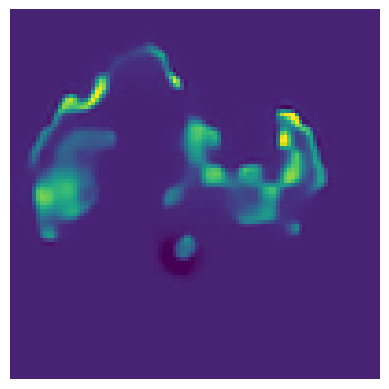

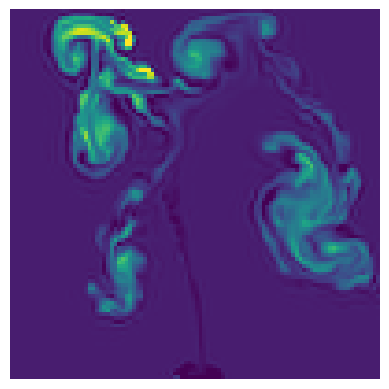

In [79]:
pred_image_animation(pred)
ground_image_animation(ground)